In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from lataq.models import EMBEDCVAE
#from lataq_reproduce.exp_dict import EXPERIMENT_INFO
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
def embedding_plot_adata(
    adata, 
    condition_key,
    components,
    palette=None,
    title=None,
    bound=0.65,
    legendtitle=None,
):
    cond = (
        adata
        .obs[condition_key]
    )
    #r2var = pc_regression(emb_pca, cond, pca.explained_variance_, components)
    #print(r2var)
    #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    import seaborn as sns
    plt.rcParams['figure.figsize'] = (3, 3)
    emb_pca = adata.obsm['X_pca']
    pgrid = sns.jointplot(
        emb_pca[:, components[0]], 
        emb_pca[:, components[1]], 
        hue=cond,
        height=3,
        #hue_order = cond_to_keep,
        palette = palette,
        #ax=ax
        marginal_kws={'common_norm': True, 'clip': [-bound, bound]},
    )
    #for i in range(emb_pca.shape[0]):
    #    ax.text(
    #        x=emb_pca[i, components[0]]+0.01,
    #        y=emb_pca[i, components[1]]+0.01,
    #        s=patient_id[i],
    #        fontsize=5
    #    )
    #pgrid.ax_joint.text(0.4, 0.7, f'$R^{2} Var: {r2var:.2f}$', fontsize=12)
    pgrid.ax_joint.grid(False)
    pgrid.ax_marg_x.grid(False)
    pgrid.ax_marg_y.grid(False)
    pgrid.ax_marg_x.set_title(title, fontsize=25)
    pgrid.ax_joint.set_xlabel(f'PC{components[0]+1}', fontweight='bold', fontsize=12)
    pgrid.ax_joint.set_ylabel(f'PC{components[1]+1}', fontweight='bold', fontsize=12)
    pgrid.ax_joint.legend(title=legendtitle,bbox_to_anchor=(1.25, 1), loc=2, fontsize=12, frameon=False, borderaxespad=0., title_fontsize=22)
    sns.despine()
    #fig = pgrid.get_figure()
    pgrid.savefig(f'sample_embeddings_{condition_key}_{components[0]}.png', dpi=500, bbox_inches='tight')

In [3]:
plt.rcParams['figure.dpi'] = 500

In [4]:
results_df = pd.read_pickle('./../benchmarks/benchmarks_new_fixed.pkl')

In [5]:
results_df['method'] = results_df['method'].astype('category')
results_df['method'] = results_df['method'].cat.rename_categories(
    {
        'embedcvae': 'scPoli',
        'lataq_noland': 'scPoli - prototypes',
        'tranvae': 'scPoli - embeddings',
        'scanvi': 'scANVI',
        'scvi': 'scVI',
        'mars': 'MARS',
        'svm': 'SVM',
        'seurat': 'Seurat v3',
        'symphony': 'Symphony'
    }
)

In [5]:
results_df['config.data'] = results_df['config.data'].astype('category')
results_df['config.data'] = results_df['config.data'].cat.rename_categories(
    {
        'pancreas': 'Pancreas',
        'pbmc': 'Immune',
        'brain': 'Brain',
        'scvelo': 'Endocrine',
        'tumor': 'Tumor',
        'lung': 'Lung',
    }
)

In [6]:
integration_methods = ['scANVI', 'scVI', 'Seurat v3', 'Symphony', 'scPoli - embeddings', 'scPoli', 'scPoli - prototypes']
classification_methods = ['scANVI', 'Seurat v3', 'SVM', 'MARS', 'scPoli - embeddings', 'scPoli']

In [7]:
map_metrics = {
    'result.NMI_cluster/label': 'bio conservation', 
    'result.ARI_cluster/label': 'bio conservation',
    'result.ASW_label': 'bio conservation', 
    'result.ASW_label/batch': 'batch correction', 
    'result.PCR_batch': 'batch correction',
    'result.isolated_label_F1': 'bio conservation', 
    'result.isolated_label_silhouette': 'bio conservation',
    'result.graph_conn': 'batch correction',
}


In [8]:
results_df['integration_scores_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
    'result.graph_conn',
]].mean(axis=1)

In [9]:
results_df['bio_conservation_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
]].mean(axis=1)
results_df['batch_correction_mean'] = results_df[[
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.graph_conn',
]].mean(axis=1)
results_df['integration_scores_weighted_mean'] = 0.4*results_df['batch_correction_mean'] + 0.6*results_df['bio_conservation_mean']

In [10]:
results_melt = pd.melt(results_df, id_vars = ['config.data', 'method'])
results_melt = results_melt[~results_melt['variable'].str.contains('time')]
results_melt['method'] = results_melt['method'].astype('category')
results_melt['method'] = results_melt['method'].cat.reorder_categories(
    [
        'scPoli',
        'scPoli - prototypes',
        'scPoli - embeddings',
        'scVI',
        'scANVI',
        'MARS',
        'Seurat v3',
        'Symphony',
        'SVM'
    ]
)

In [11]:
results_melt['metric_type'] = results_melt['variable'].map(map_metrics)

In [12]:
results_melt

,config.data,method,variable,value,metric_type
108,pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,pbmc,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,scvelo,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
859,pbmc,Symphony,integration_scores_weighted_mean,0.757735,NaN
860,scvelo,Symphony,integration_scores_weighted_mean,0.545792,NaN
861,lung,Symphony,integration_scores_weighted_mean,0.612712,NaN
862,tumor,Symphony,integration_scores_weighted_mean,0.548210,NaN


In [13]:
results_melt.groupby(['method', 'variable']).mean()

value
method variable                                  
scPoli batch_correction_mean             0.689169
       bio_conservation_mean             0.714558
       integration_scores_mean           0.705037
       integration_scores_weighted_mean  0.704403
       result.ARI_cluster/label          0.651794
...                                           ...
SVM    result.f1-score-macro             0.732632
       result.f1-score-weighted          0.795340
       result.graph_conn                      NaN
       result.isolated_label_F1               NaN
       result.isolated_label_silhouette       NaN

[126 rows x 1 columns]

In [14]:
palette_dict = {
    'scPoli': '#6b00b3',
    'scPoli - prototypes': '#ad33ff',
    'scPoli - embeddings': '#e0b3ff',
    'scVI': '#3498DB',
    'scANVI': '#85C1E9',
    'MARS': '#616A6B',
    'Seurat v3': '#CB4335',
    'Symphony': '#F1948A',
    'SVM': '#F7DC6F'
}

In [15]:
results_melt[results_melt['variable'] == 'integration_scores_mean']

,config.data,method,variable,value,metric_type
648,pancreas,scANVI,integration_scores_mean,0.733344,NaN
649,pbmc,scANVI,integration_scores_mean,0.820540,NaN
650,brain,scANVI,integration_scores_mean,0.639530,NaN
651,scvelo,scANVI,integration_scores_mean,0.606063,NaN
652,tumor,scANVI,integration_scores_mean,0.558503,NaN
653,lung,scANVI,integration_scores_mean,0.650825,NaN
654,pancreas,scVI,integration_scores_mean,0.732511,NaN
655,pbmc,scVI,integration_scores_mean,0.775826,NaN
656,brain,scVI,integration_scores_mean,0.613147,NaN
657,scvelo,scVI,integration_scores_mean,0.493400,NaN


<ipython-input-16-b36cc26aa224>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


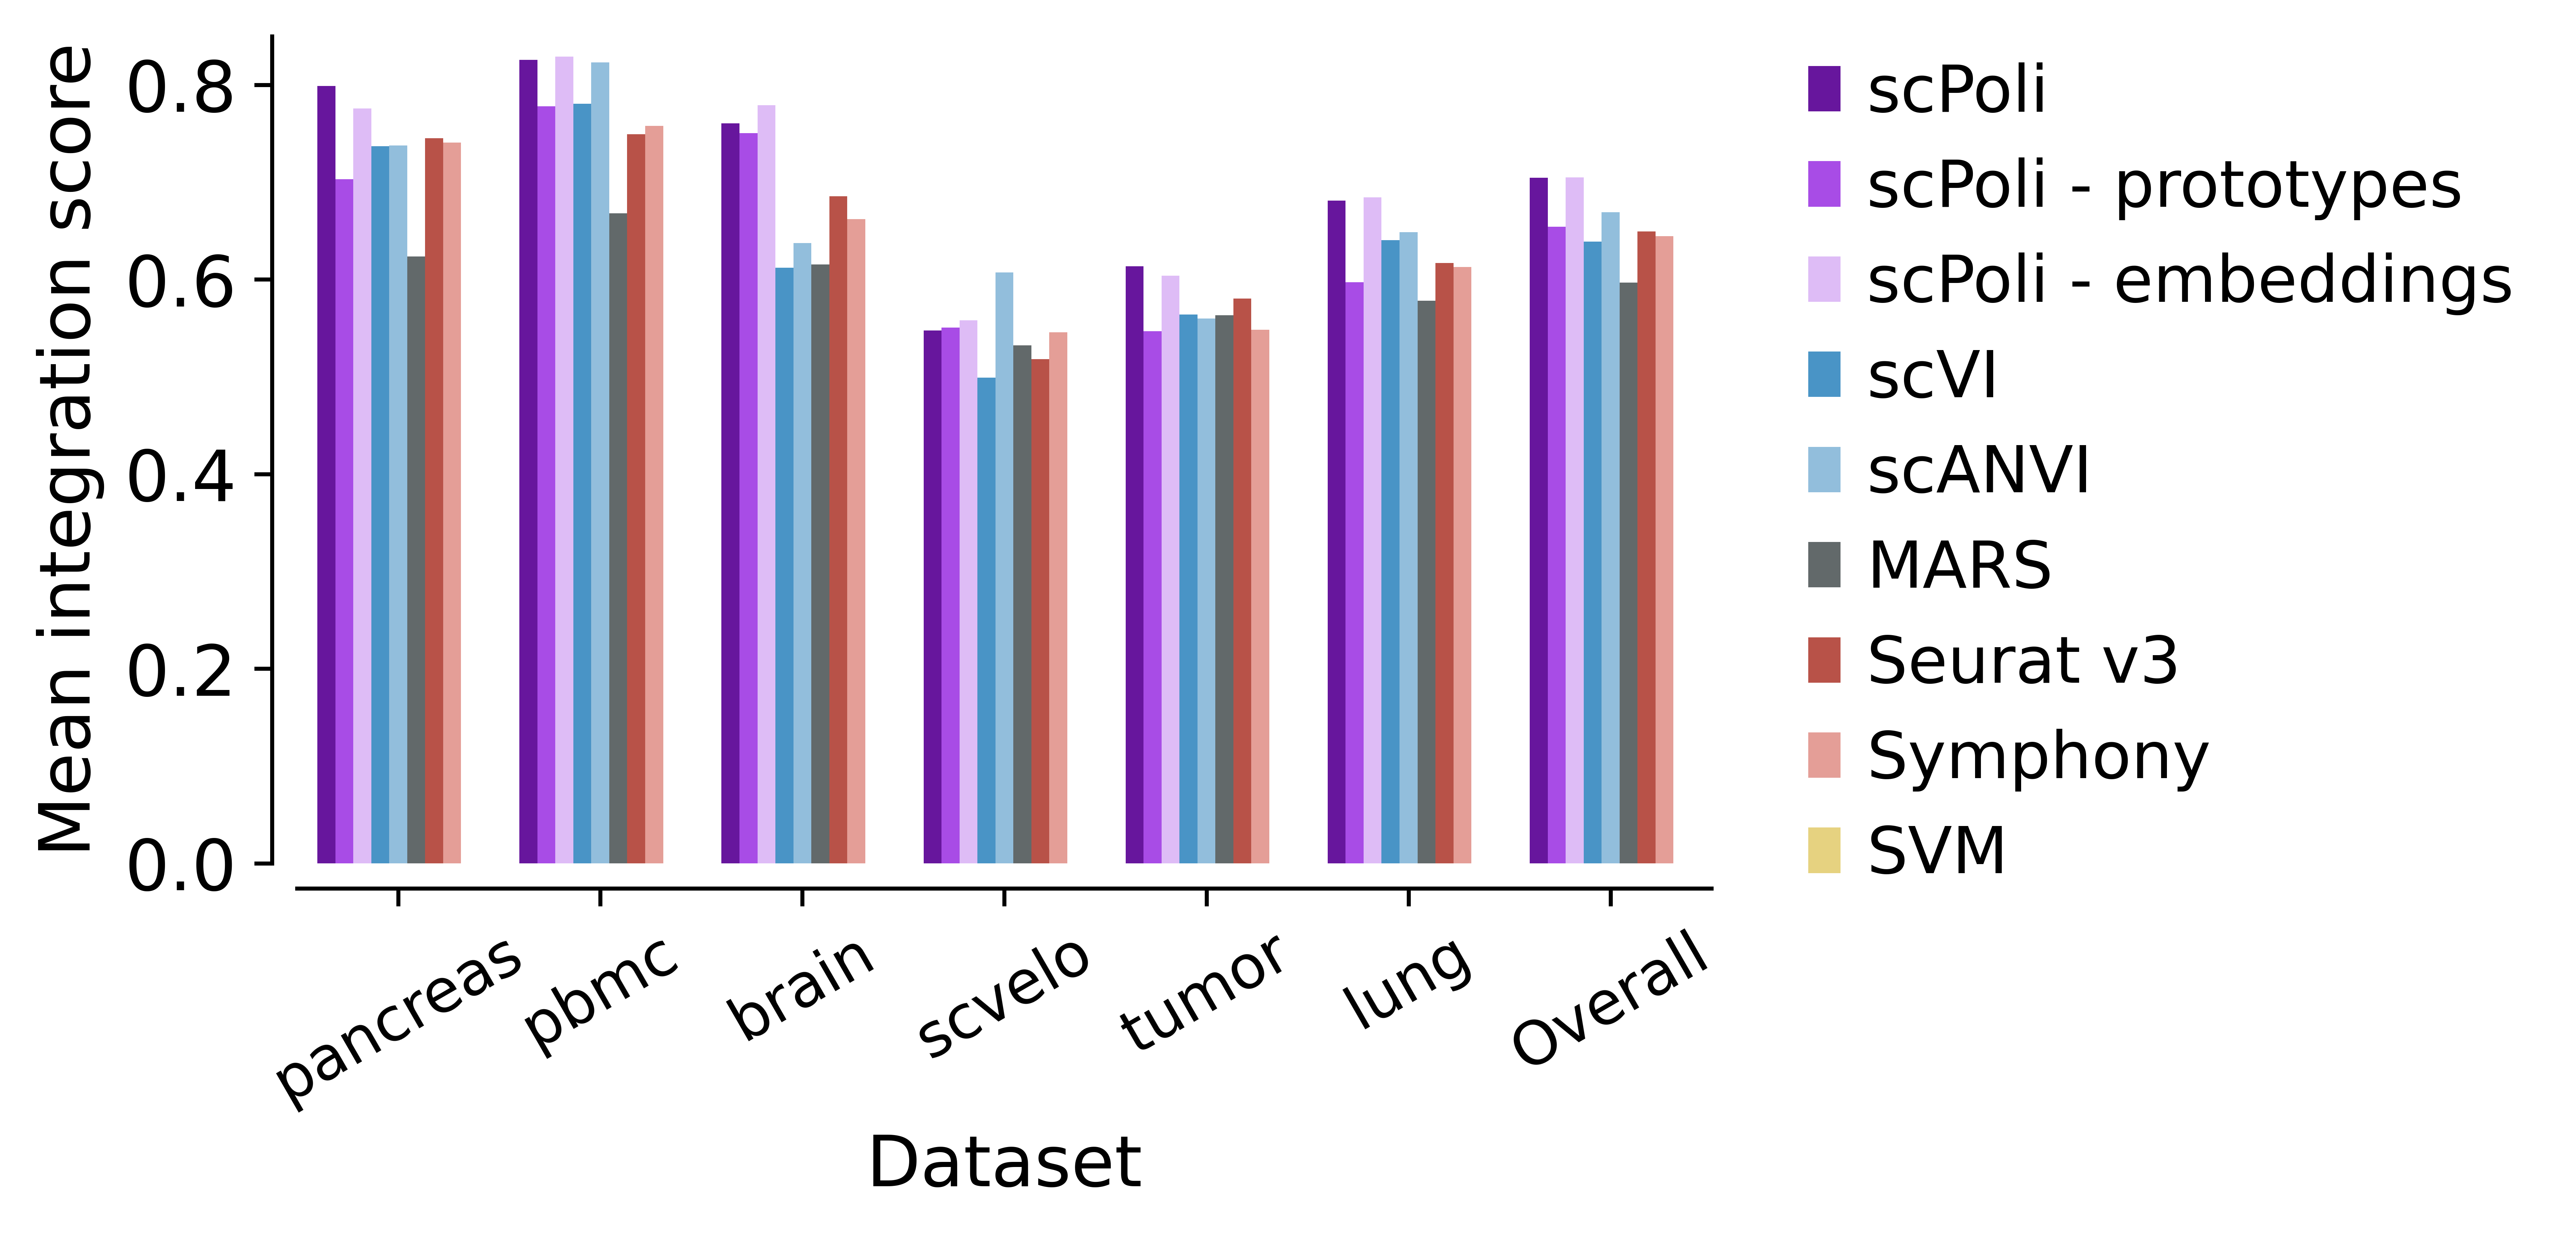

In [16]:
df_plot = results_melt[
    (results_melt['variable'] == 'integration_scores_weighted_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
#ax.set_title('Integration scores mean')
ax.set_ylabel('Mean integration score')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
#ax.get_legend().remove()
ax.set_ylim([0, 0.85])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/legend.png', dpi=600, bbox_inches='tight')

<ipython-input-28-13a91617e109>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


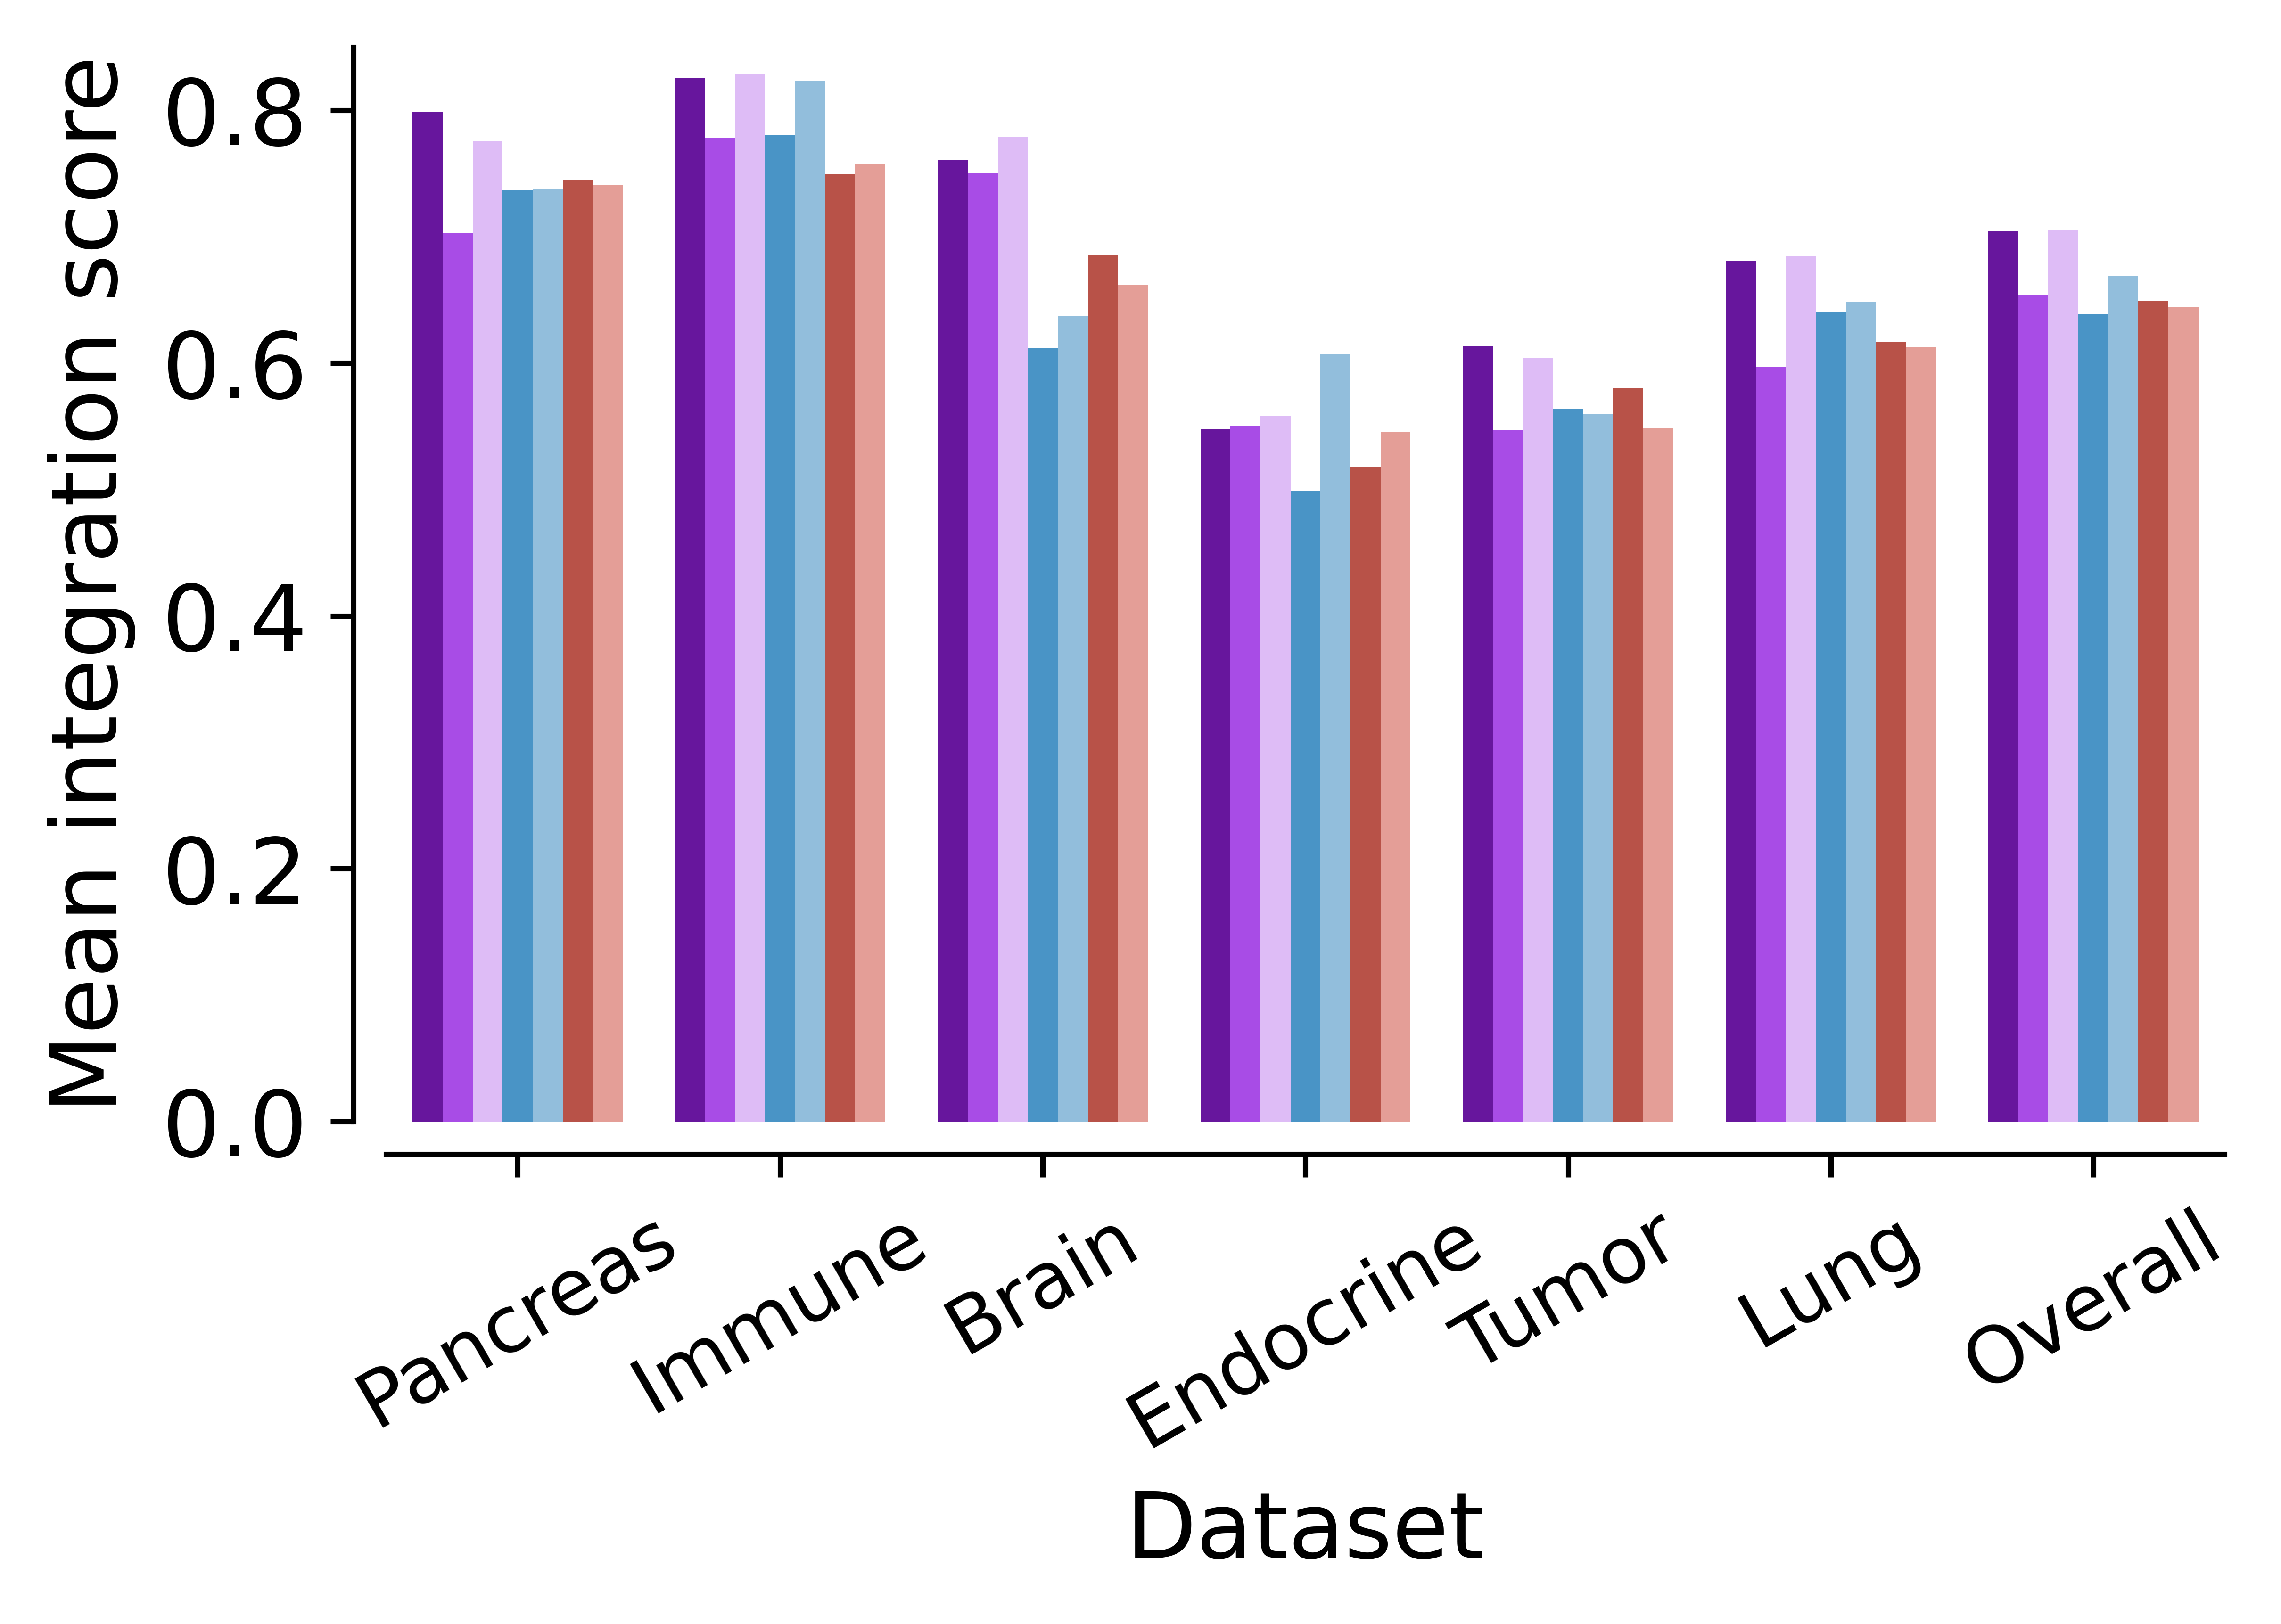

In [28]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'integration_scores_weighted_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
#ax.set_title('Integration scores mean')
ax.set_ylabel('Mean integration score')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_ylim([0, 0.85])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')

In [33]:
mean_df = mean_df.set_index('method')['value']

In [34]:
(mean_df.loc['scPoli'] - mean_df.loc['scANVI']) / mean_df.loc['scANVI']

0.05304448906595451

In [35]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'bio_conservation_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
mean_df = mean_df.set_index('method')['value']
(mean_df.loc['scPoli'] - mean_df.loc['scANVI']) / mean_df.loc['scANVI']

<ipython-input-35-8955ba3ecfd3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


0.08870038291796514

In [36]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

df_plot

<ipython-input-36-7cc8e29b0b88>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


,config.data,method,variable,value,metric_type
108,Pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,Immune,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,Brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,Endocrine,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,Tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
9,Overall,scANVI,NaN,0.656341,bio conservation
10,Overall,Seurat v3,NaN,0.708210,batch correction
11,Overall,Seurat v3,NaN,0.609780,bio conservation
12,Overall,Symphony,NaN,0.728629,batch correction


<ipython-input-51-8d4cfa30480c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


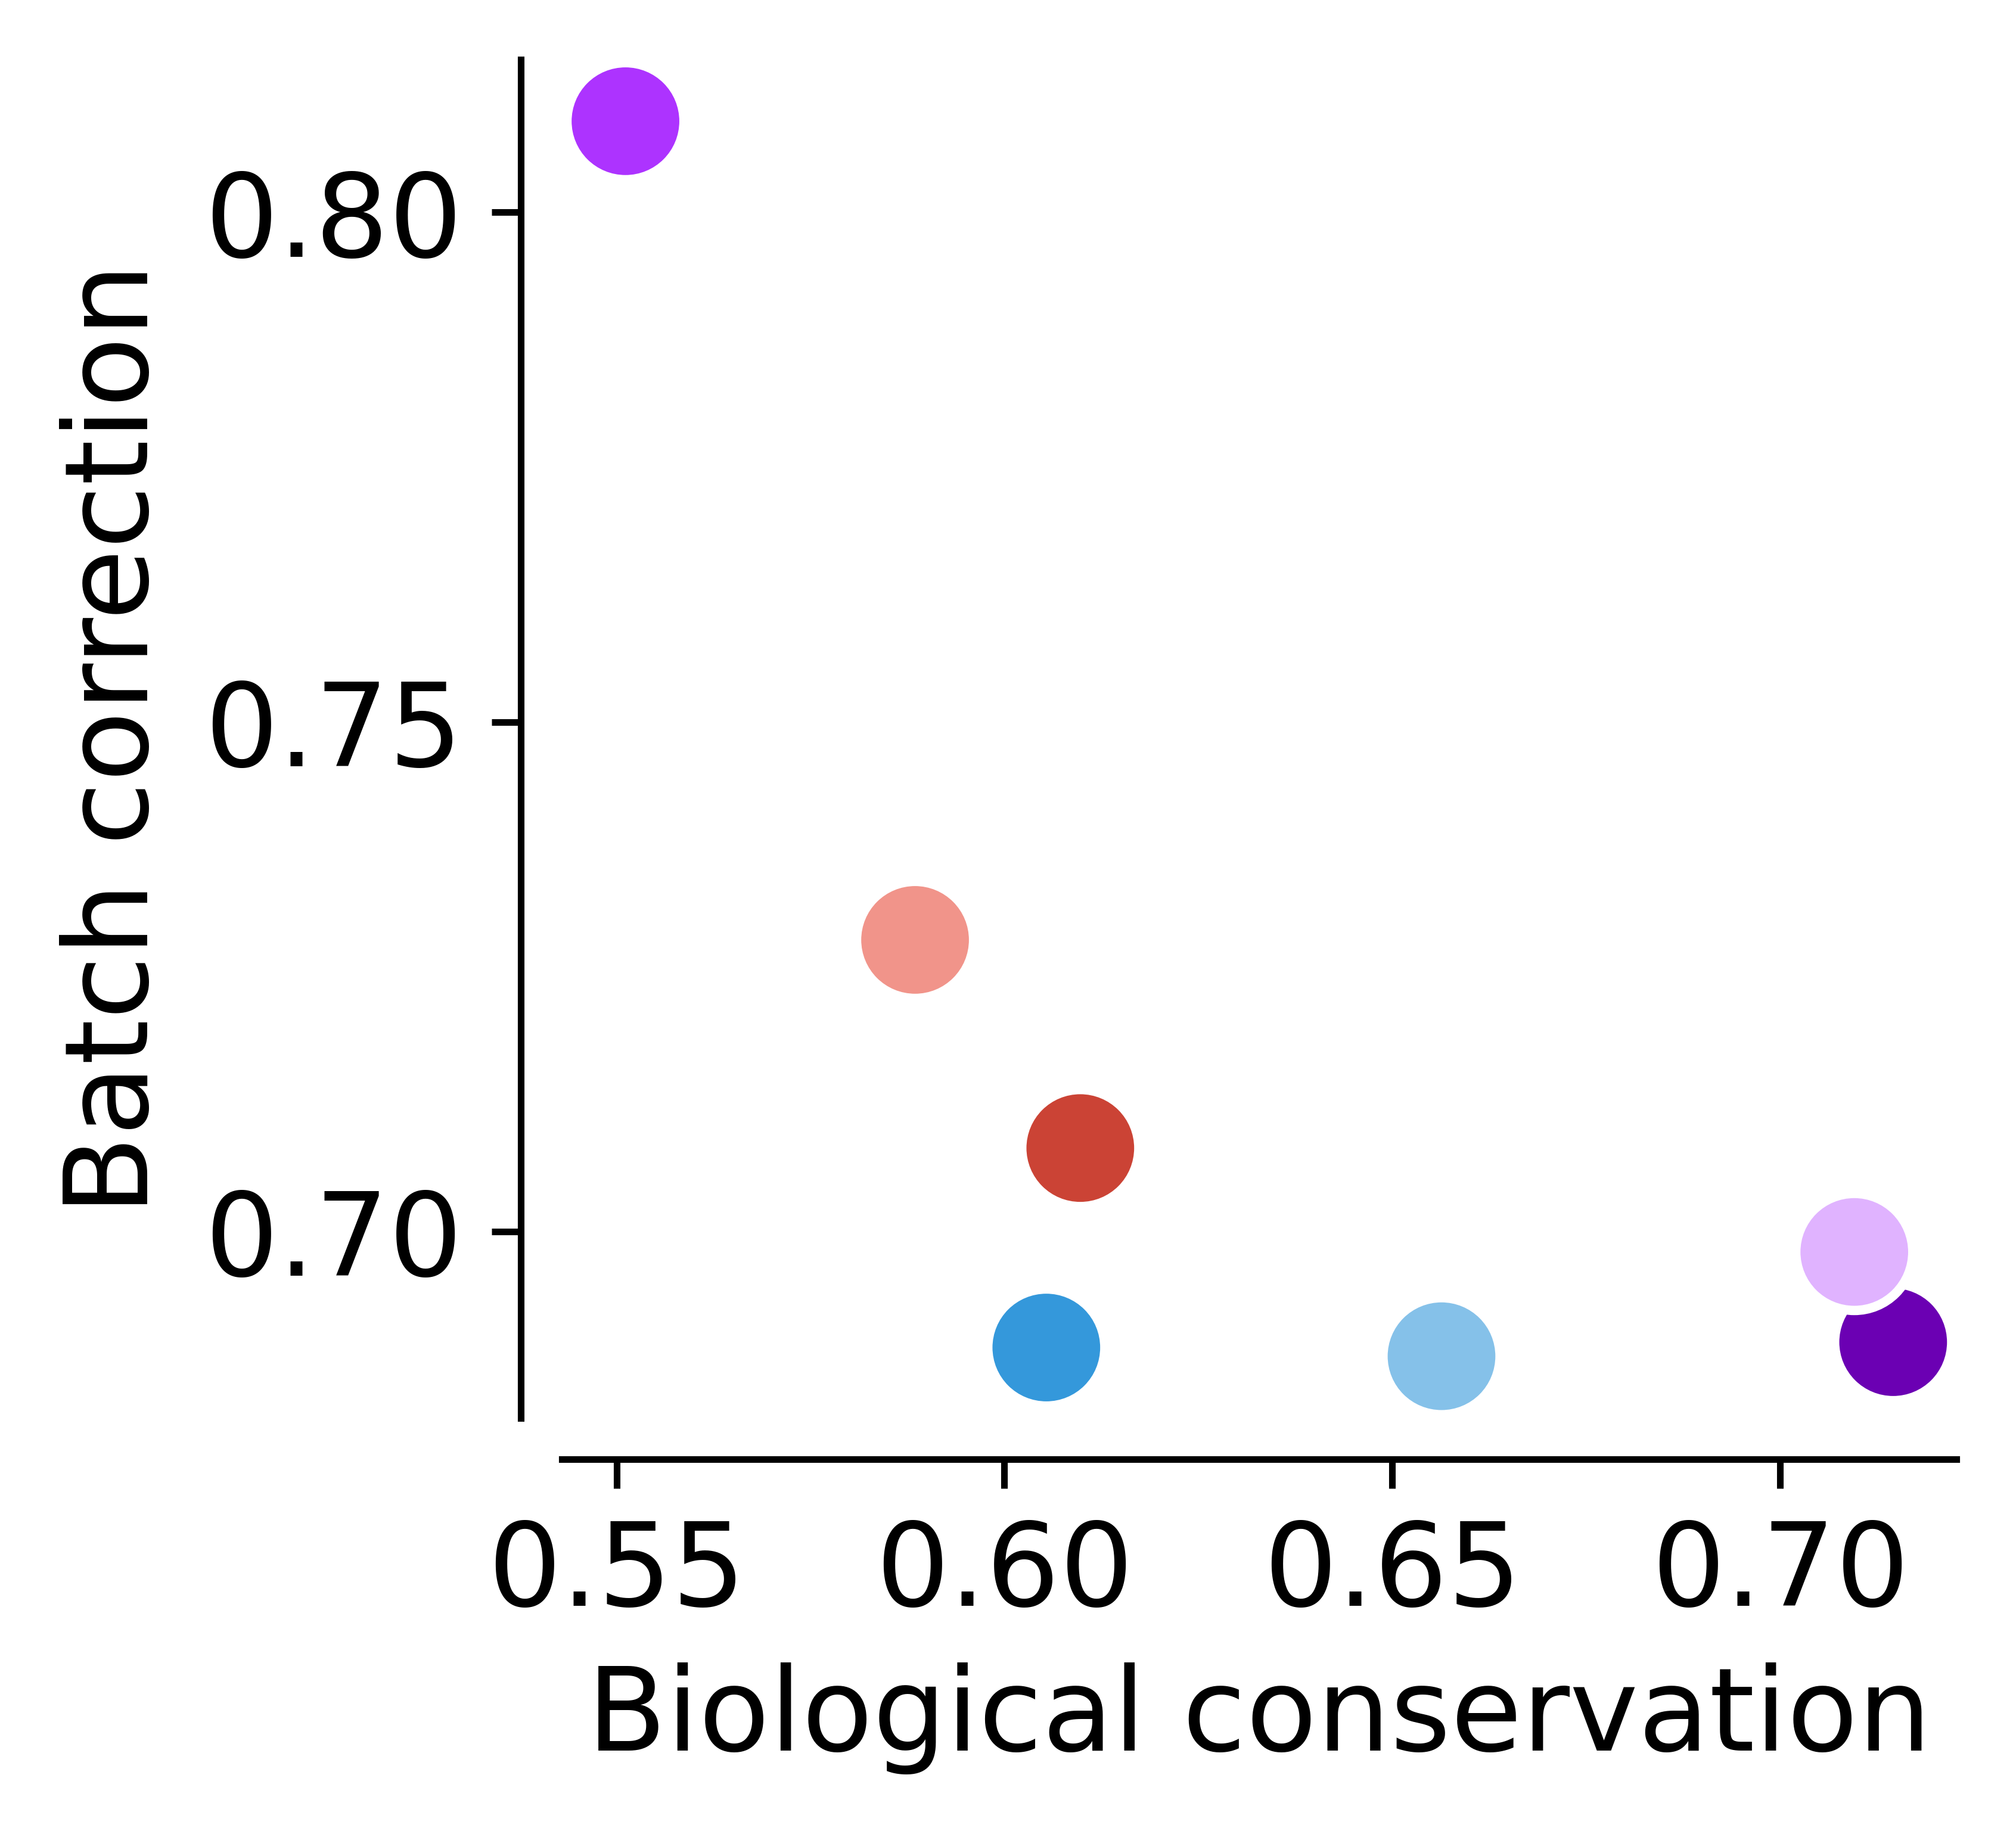

In [51]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)
d = df_plot[df_plot['config.data'] == 'Overall'].set_index(['method', 'metric_type']).unstack()['value']

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(
    d['bio conservation'], 
    d['batch correction'],
    palette=palette_dict,
    hue=d.index, 
    ax=ax,
    s=200,
)
#ax.set_title('Integration performance')
ax.set_ylabel('Batch correction')
ax.set_xlabel('Biological conservation')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.grid('off')
ax.grid(b=None)
#l = ax.get_xticklabels()
sns.despine(offset=5)
#ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_biobatch.png', dpi=600, bbox_inches='tight')

<ipython-input-52-febe7943c779>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
No handles with labels found to put in legend.


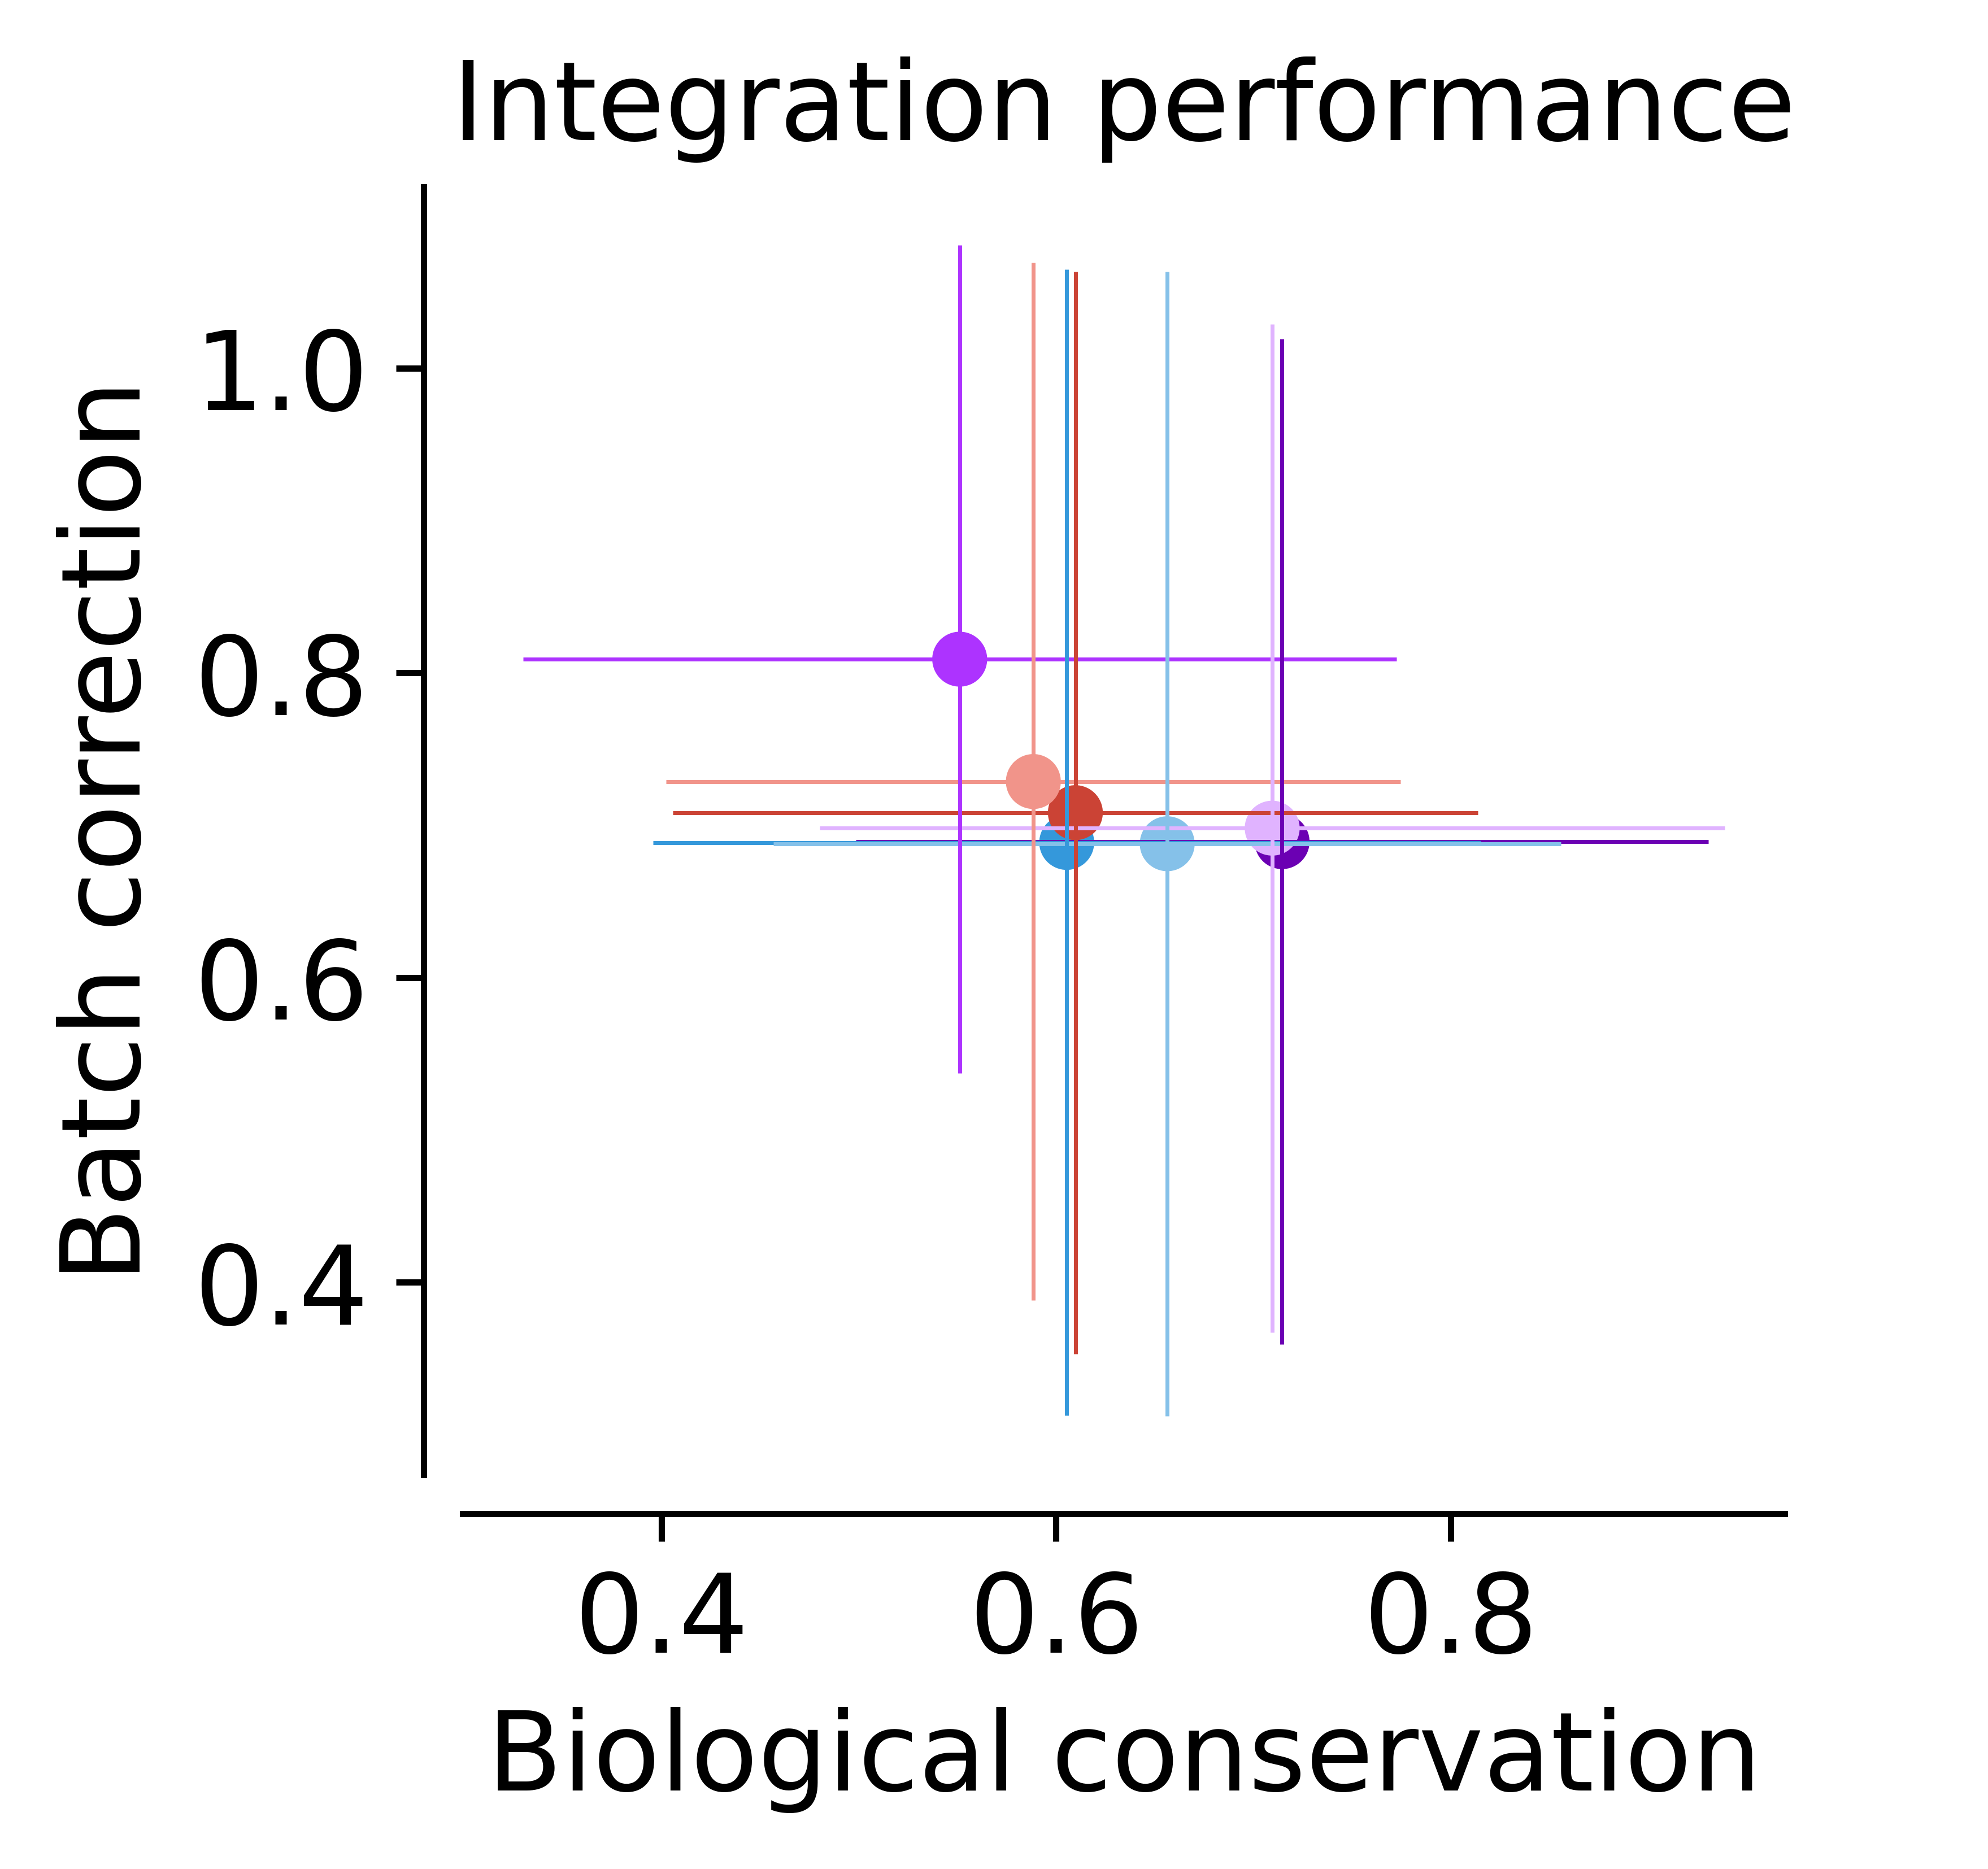

In [52]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)
d = df_plot[df_plot['config.data'] == 'Overall'].set_index(['method', 'metric_type']).unstack()['value']


std_df = df_plot.groupby(['method', 'metric_type']).std()
std_df = std_df.reset_index()
std_df['index'] = 'Overall (std)'
std_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(std_df)
d_std = df_plot[df_plot['config.data'] == 'Overall (std)'].set_index(['method', 'metric_type']).unstack()['value']

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.errorbar(
    x=d['bio conservation'].values, 
    y=d['batch correction'].values,
    #c=[palette_dict[i] for i in d.index.tolist()],
    xerr=d_std['bio conservation'].values,
    yerr=d_std['batch correction'].values,
    linewidth=0,
    elinewidth=0.5,
    ecolor=[palette_dict[i] for i in d.index.tolist()],
    #palette=palette_dict,
    #hue=d.index, 
    #ax=ax,
    #s=200,
)
ax.scatter(
    x=d['bio conservation'].values, 
    y=d['batch correction'].values,
    c=[palette_dict[i] for i in d.index.tolist()],
    #palette=palette_dict,
    #hue=d.index, 
    #ax=ax,
    #s=200,
)
ax.set_title('Integration performance')
ax.set_ylabel('Batch correction')
ax.set_xlabel('Biological conservation')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.grid('off')
ax.grid(b=None)
#l = ax.get_xticklabels()
sns.despine(offset=5)
#ax.set_xticklabels(l, fontsize=12, rotation=30)
#fig.savefig('figure2/benchmark_biobatch.png', dpi=600, bbox_inches='tight')

In [41]:
d_std

metric_type,batch correction,bio conservation
method,,
scPoli,0.329933,0.216064
scPoli - prototypes,0.271609,0.221332
CVAE + prototypes,0.330824,0.229412
scVI,0.376208,0.209779
scANVI,0.375678,0.199529
Seurat v3,0.355172,0.204083
Symphony,0.340514,0.186120


<ipython-input-53-e978048c15a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


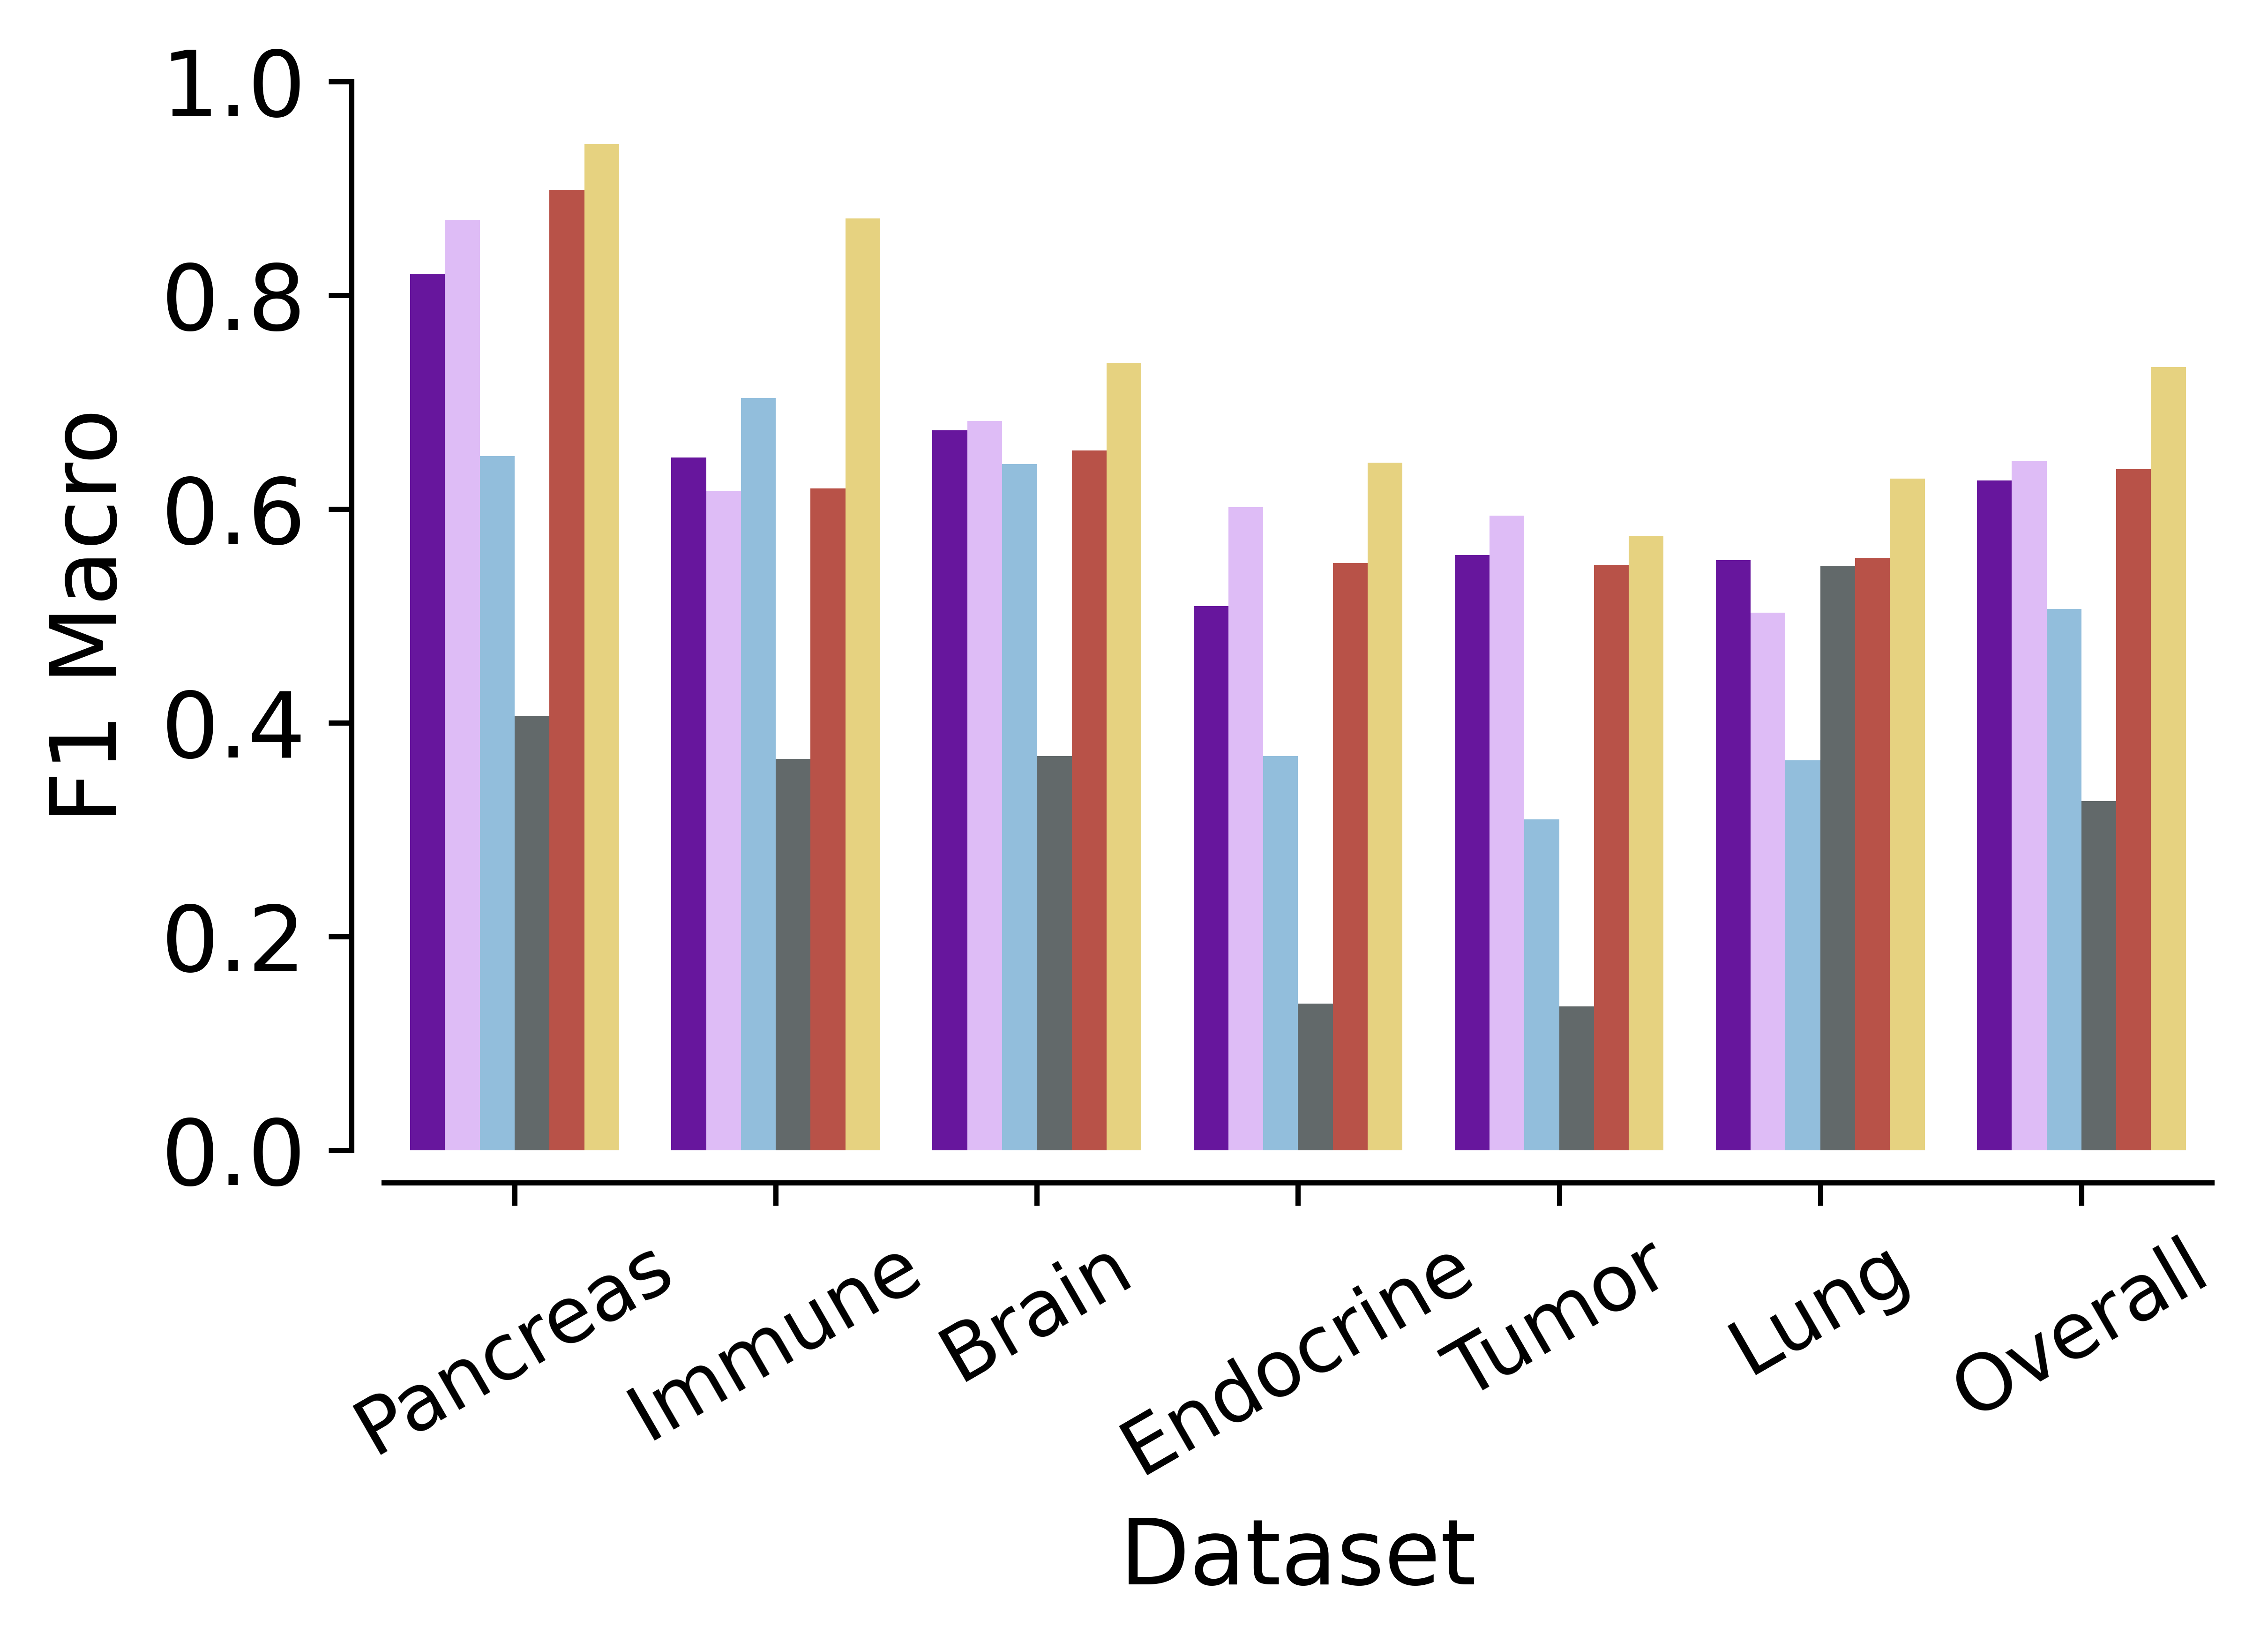

In [53]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-macro')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_ylabel('F1 Macro')
#ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_f1macro.png', dpi=600, bbox_inches='tight')

<ipython-input-54-bb5783e244f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


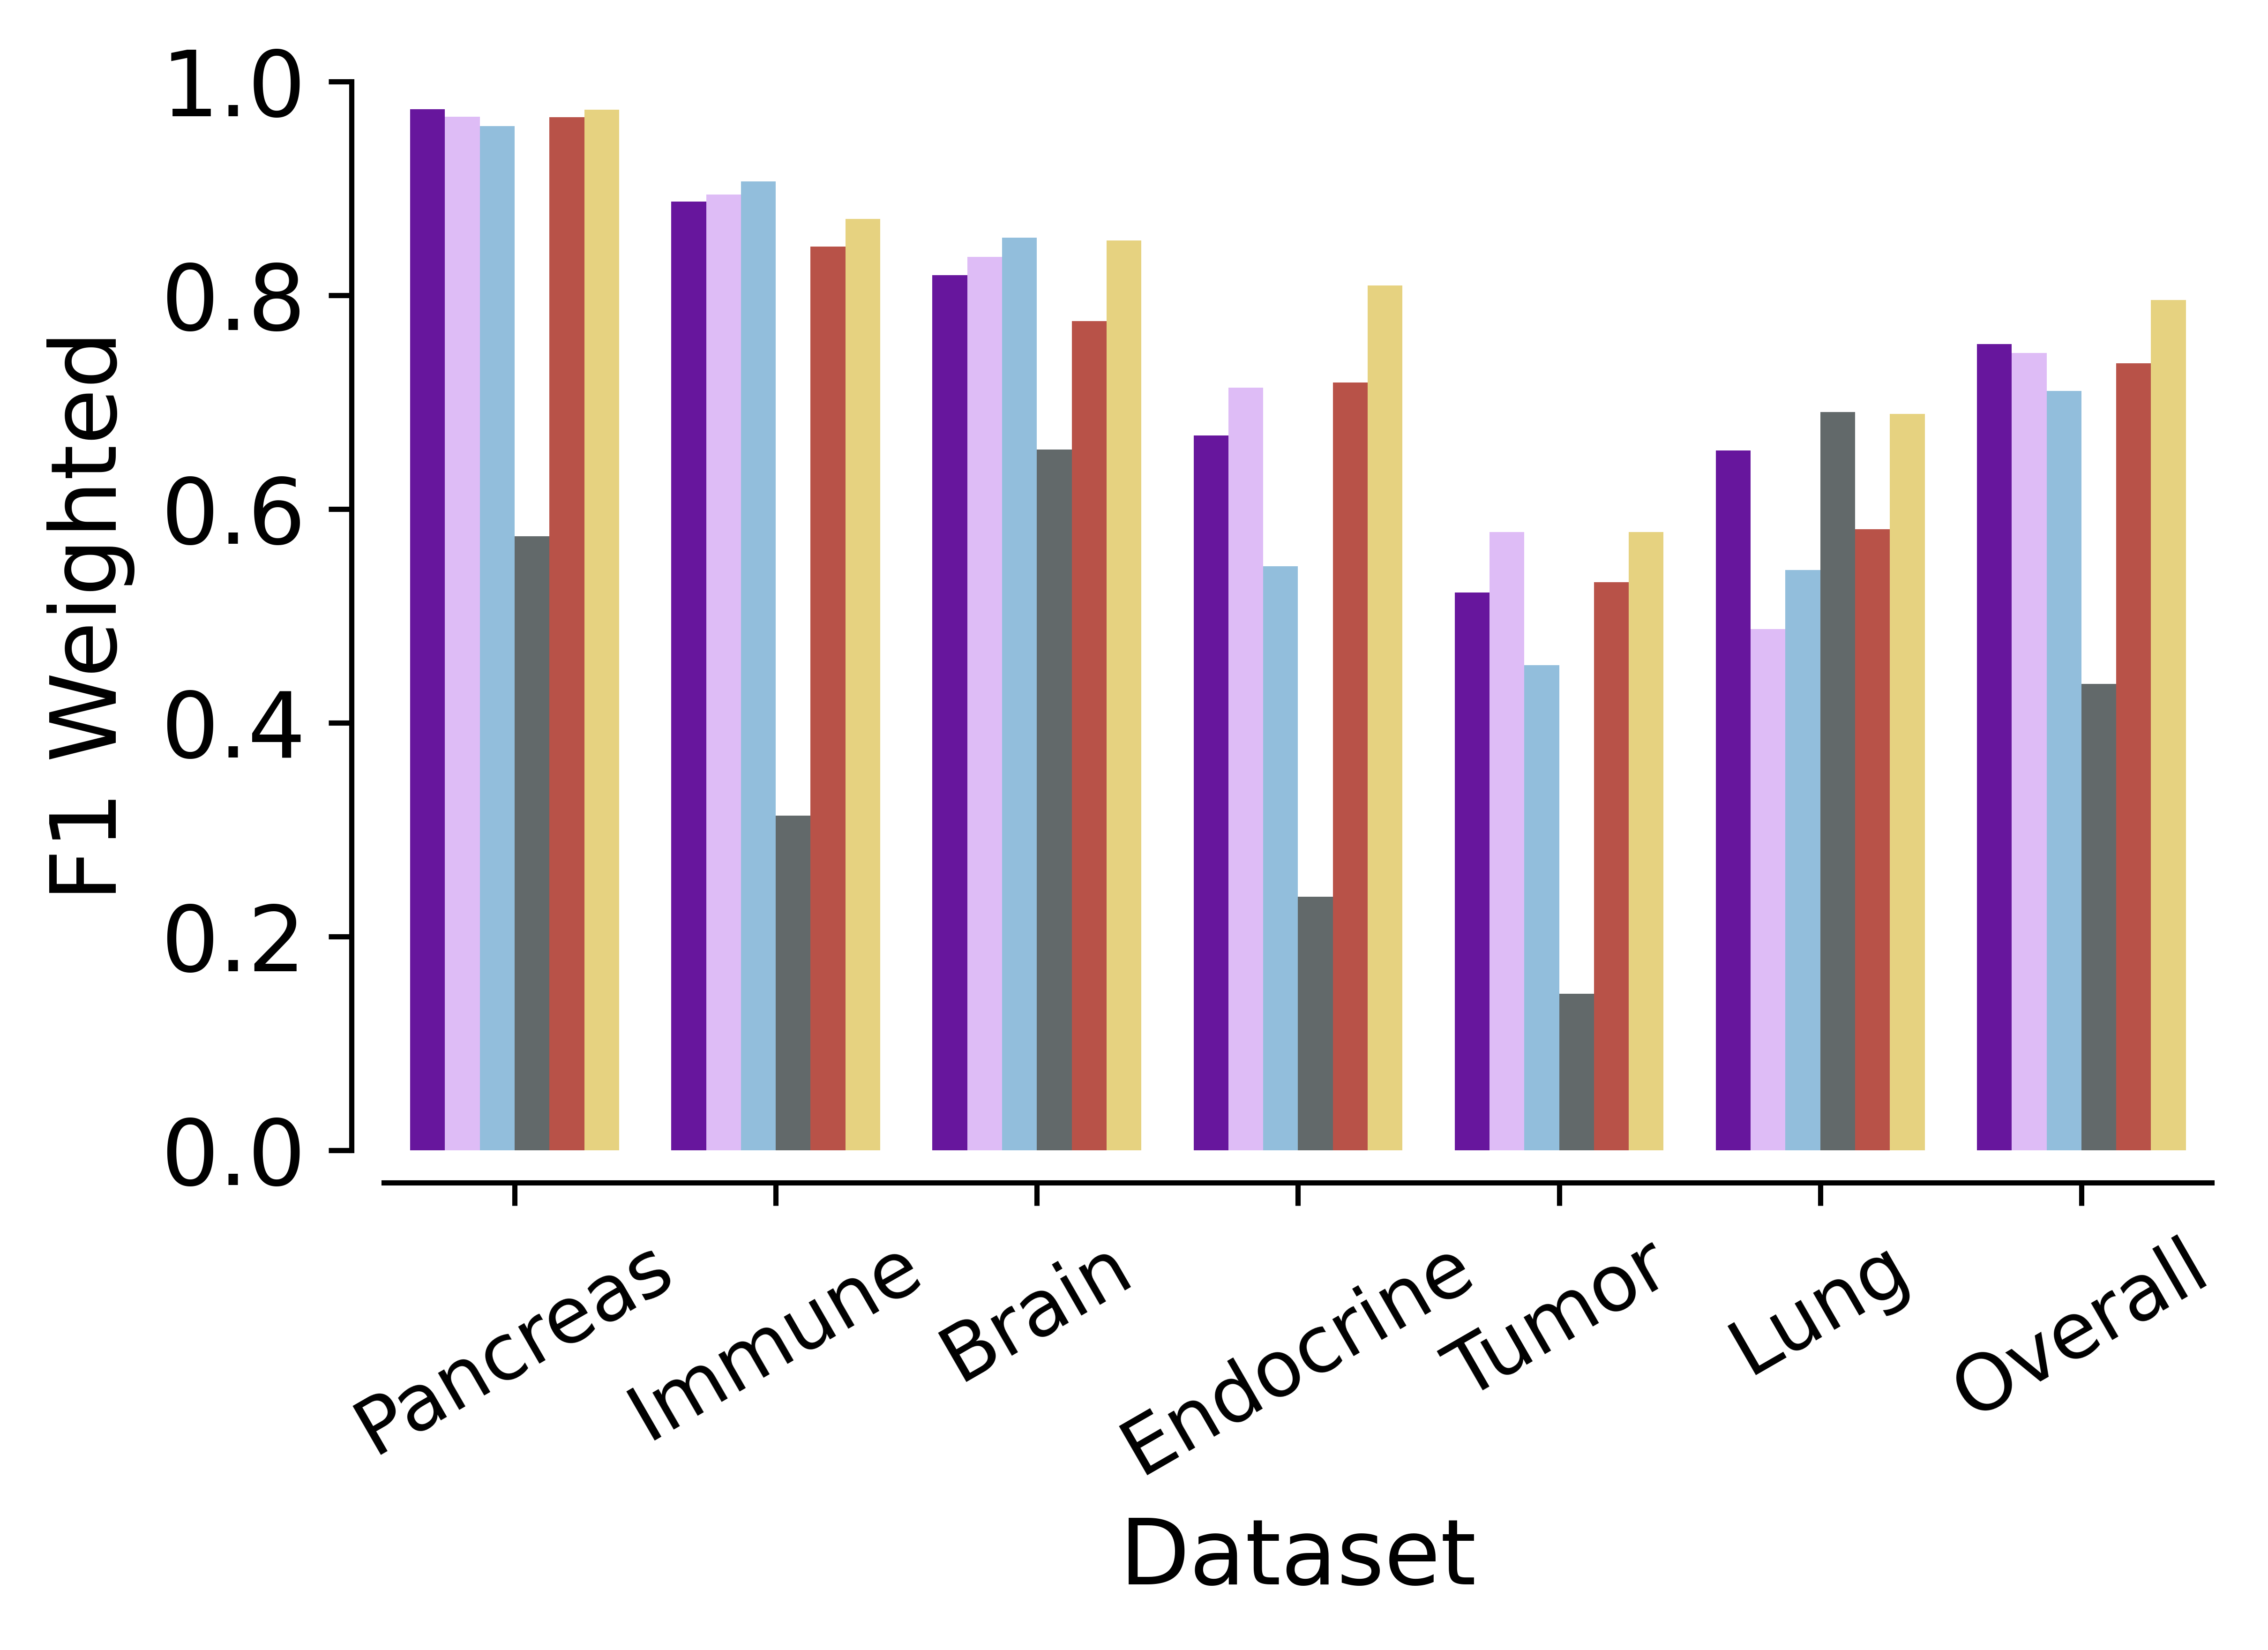

In [54]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-weighted')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_ylabel('F1 Weighted')
#ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_f1weighted.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


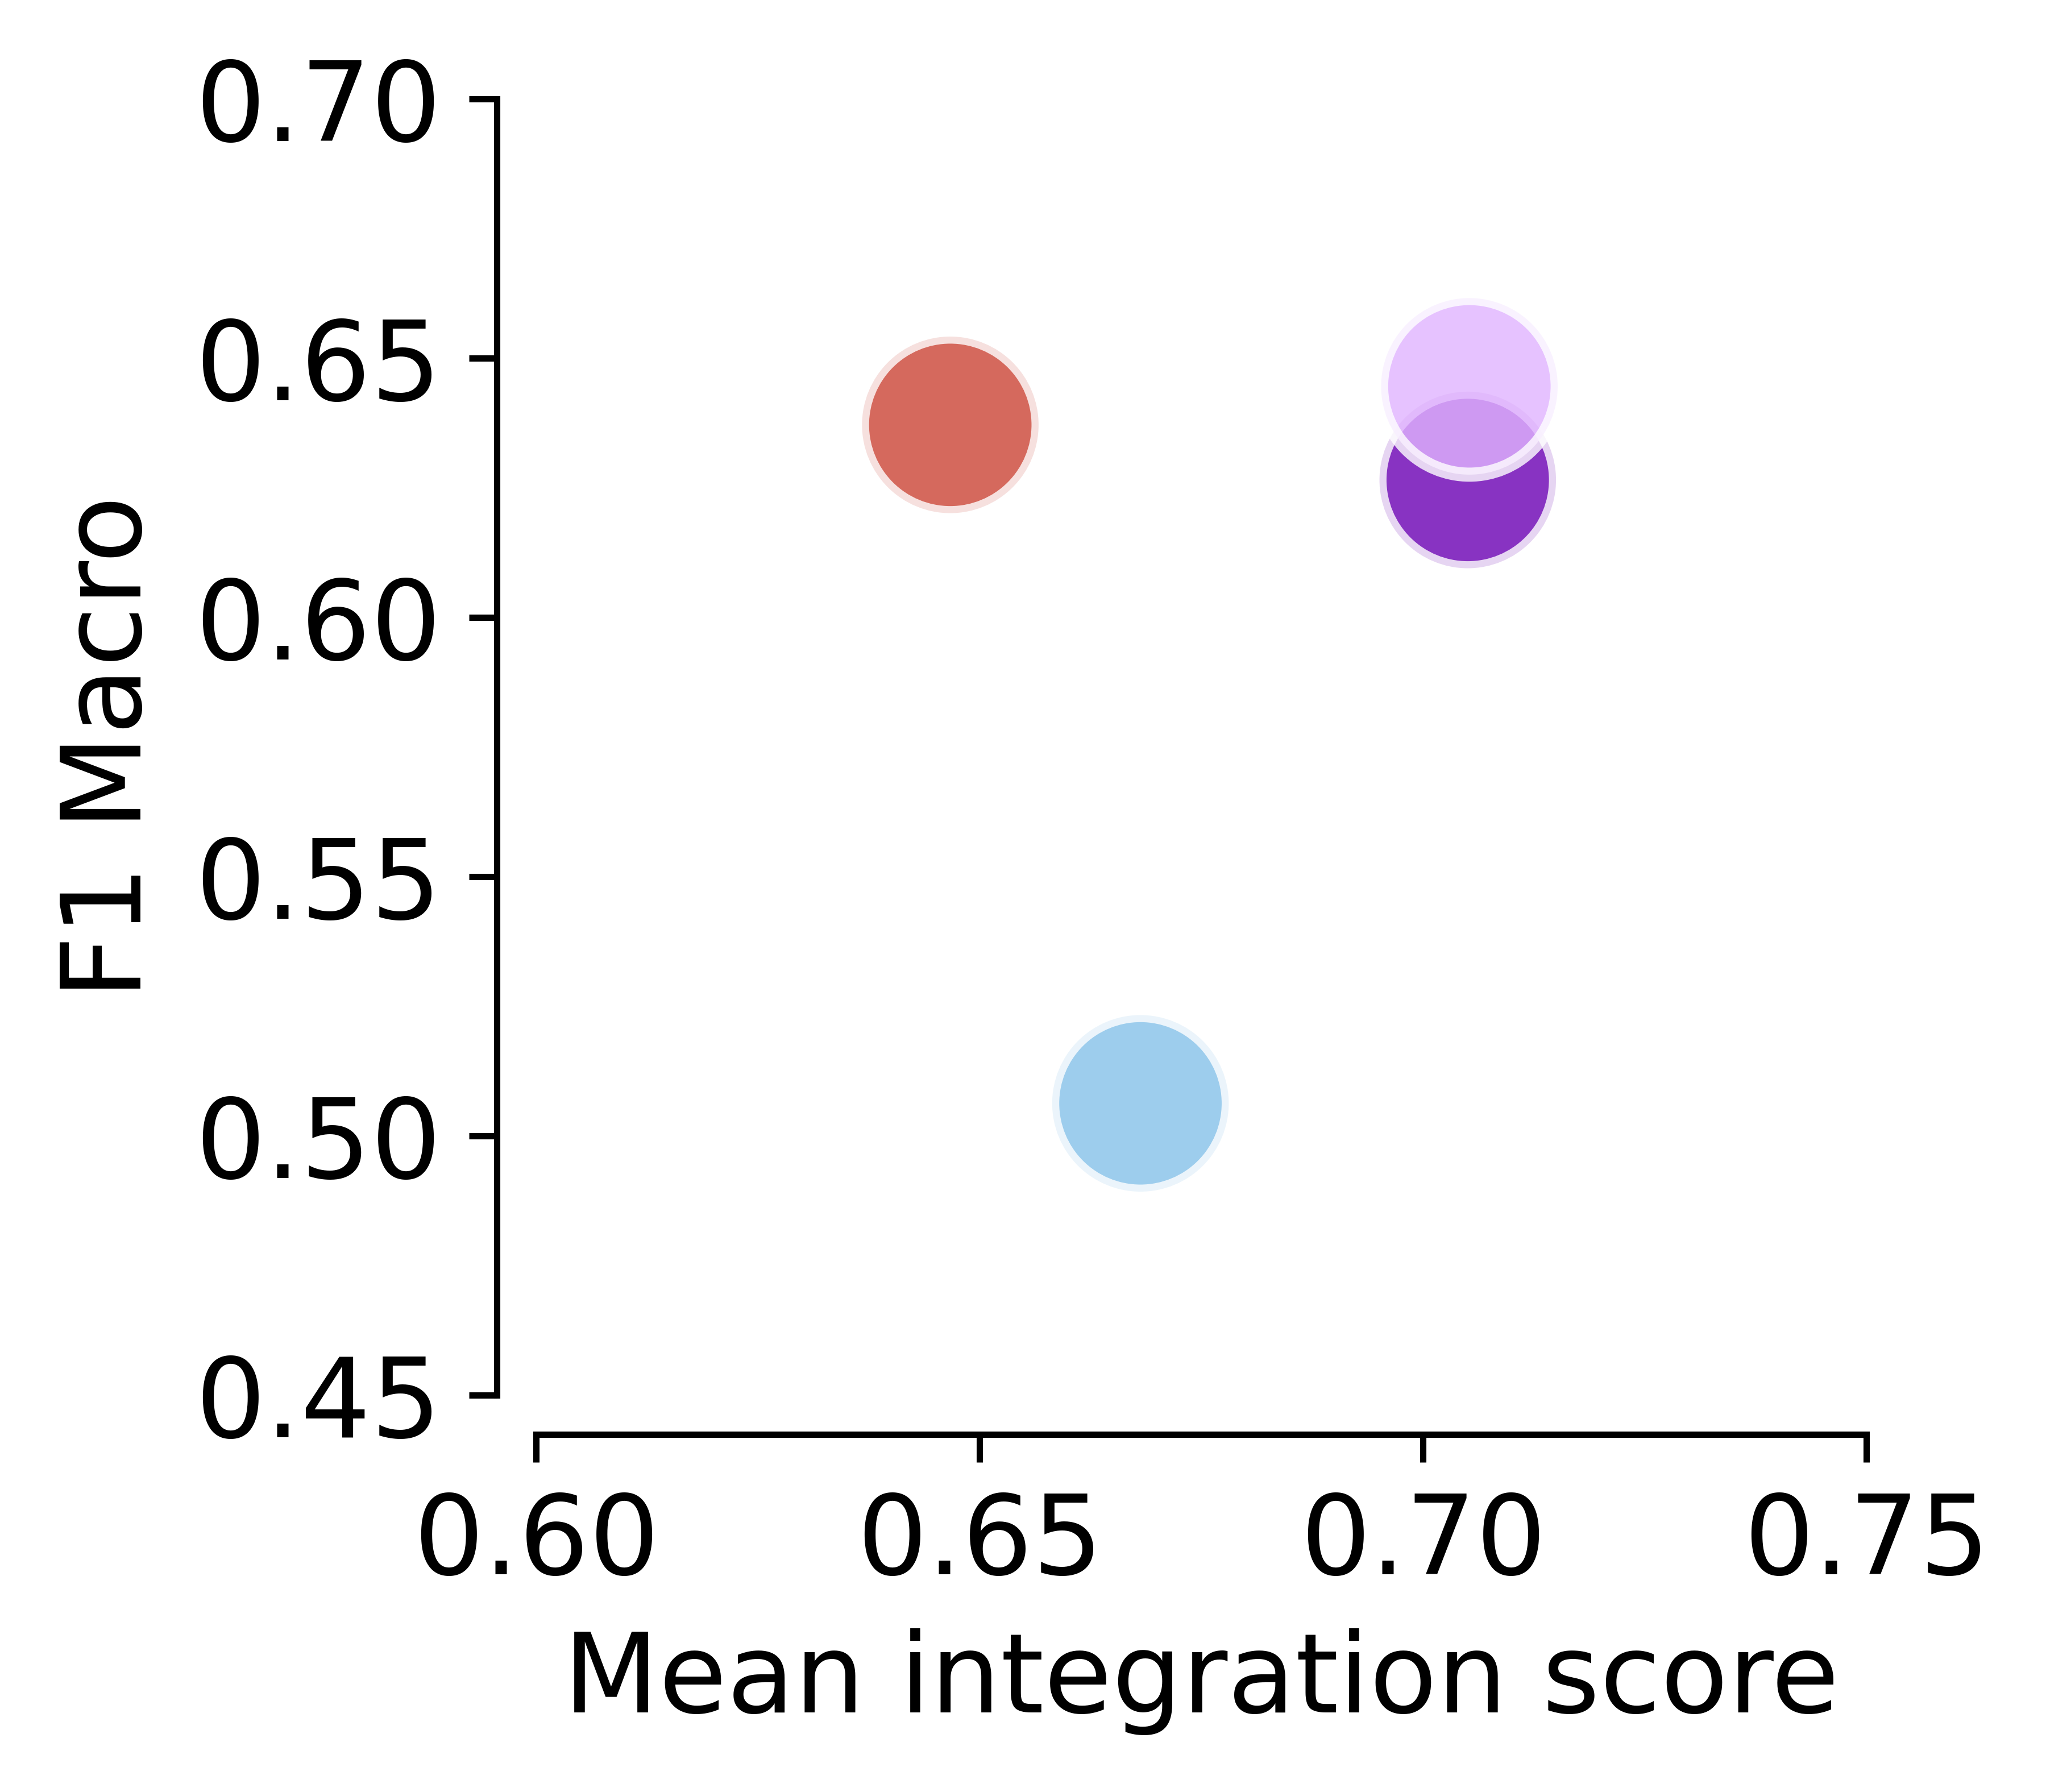

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-macro'],
    hue=df_mean.index,
    #style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=500,
    alpha=0.8,
)
ax.set_ylabel('F1 Macro')
ax.set_xlabel('Mean integration score')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.45, 0.7])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_comparison_f1macro.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


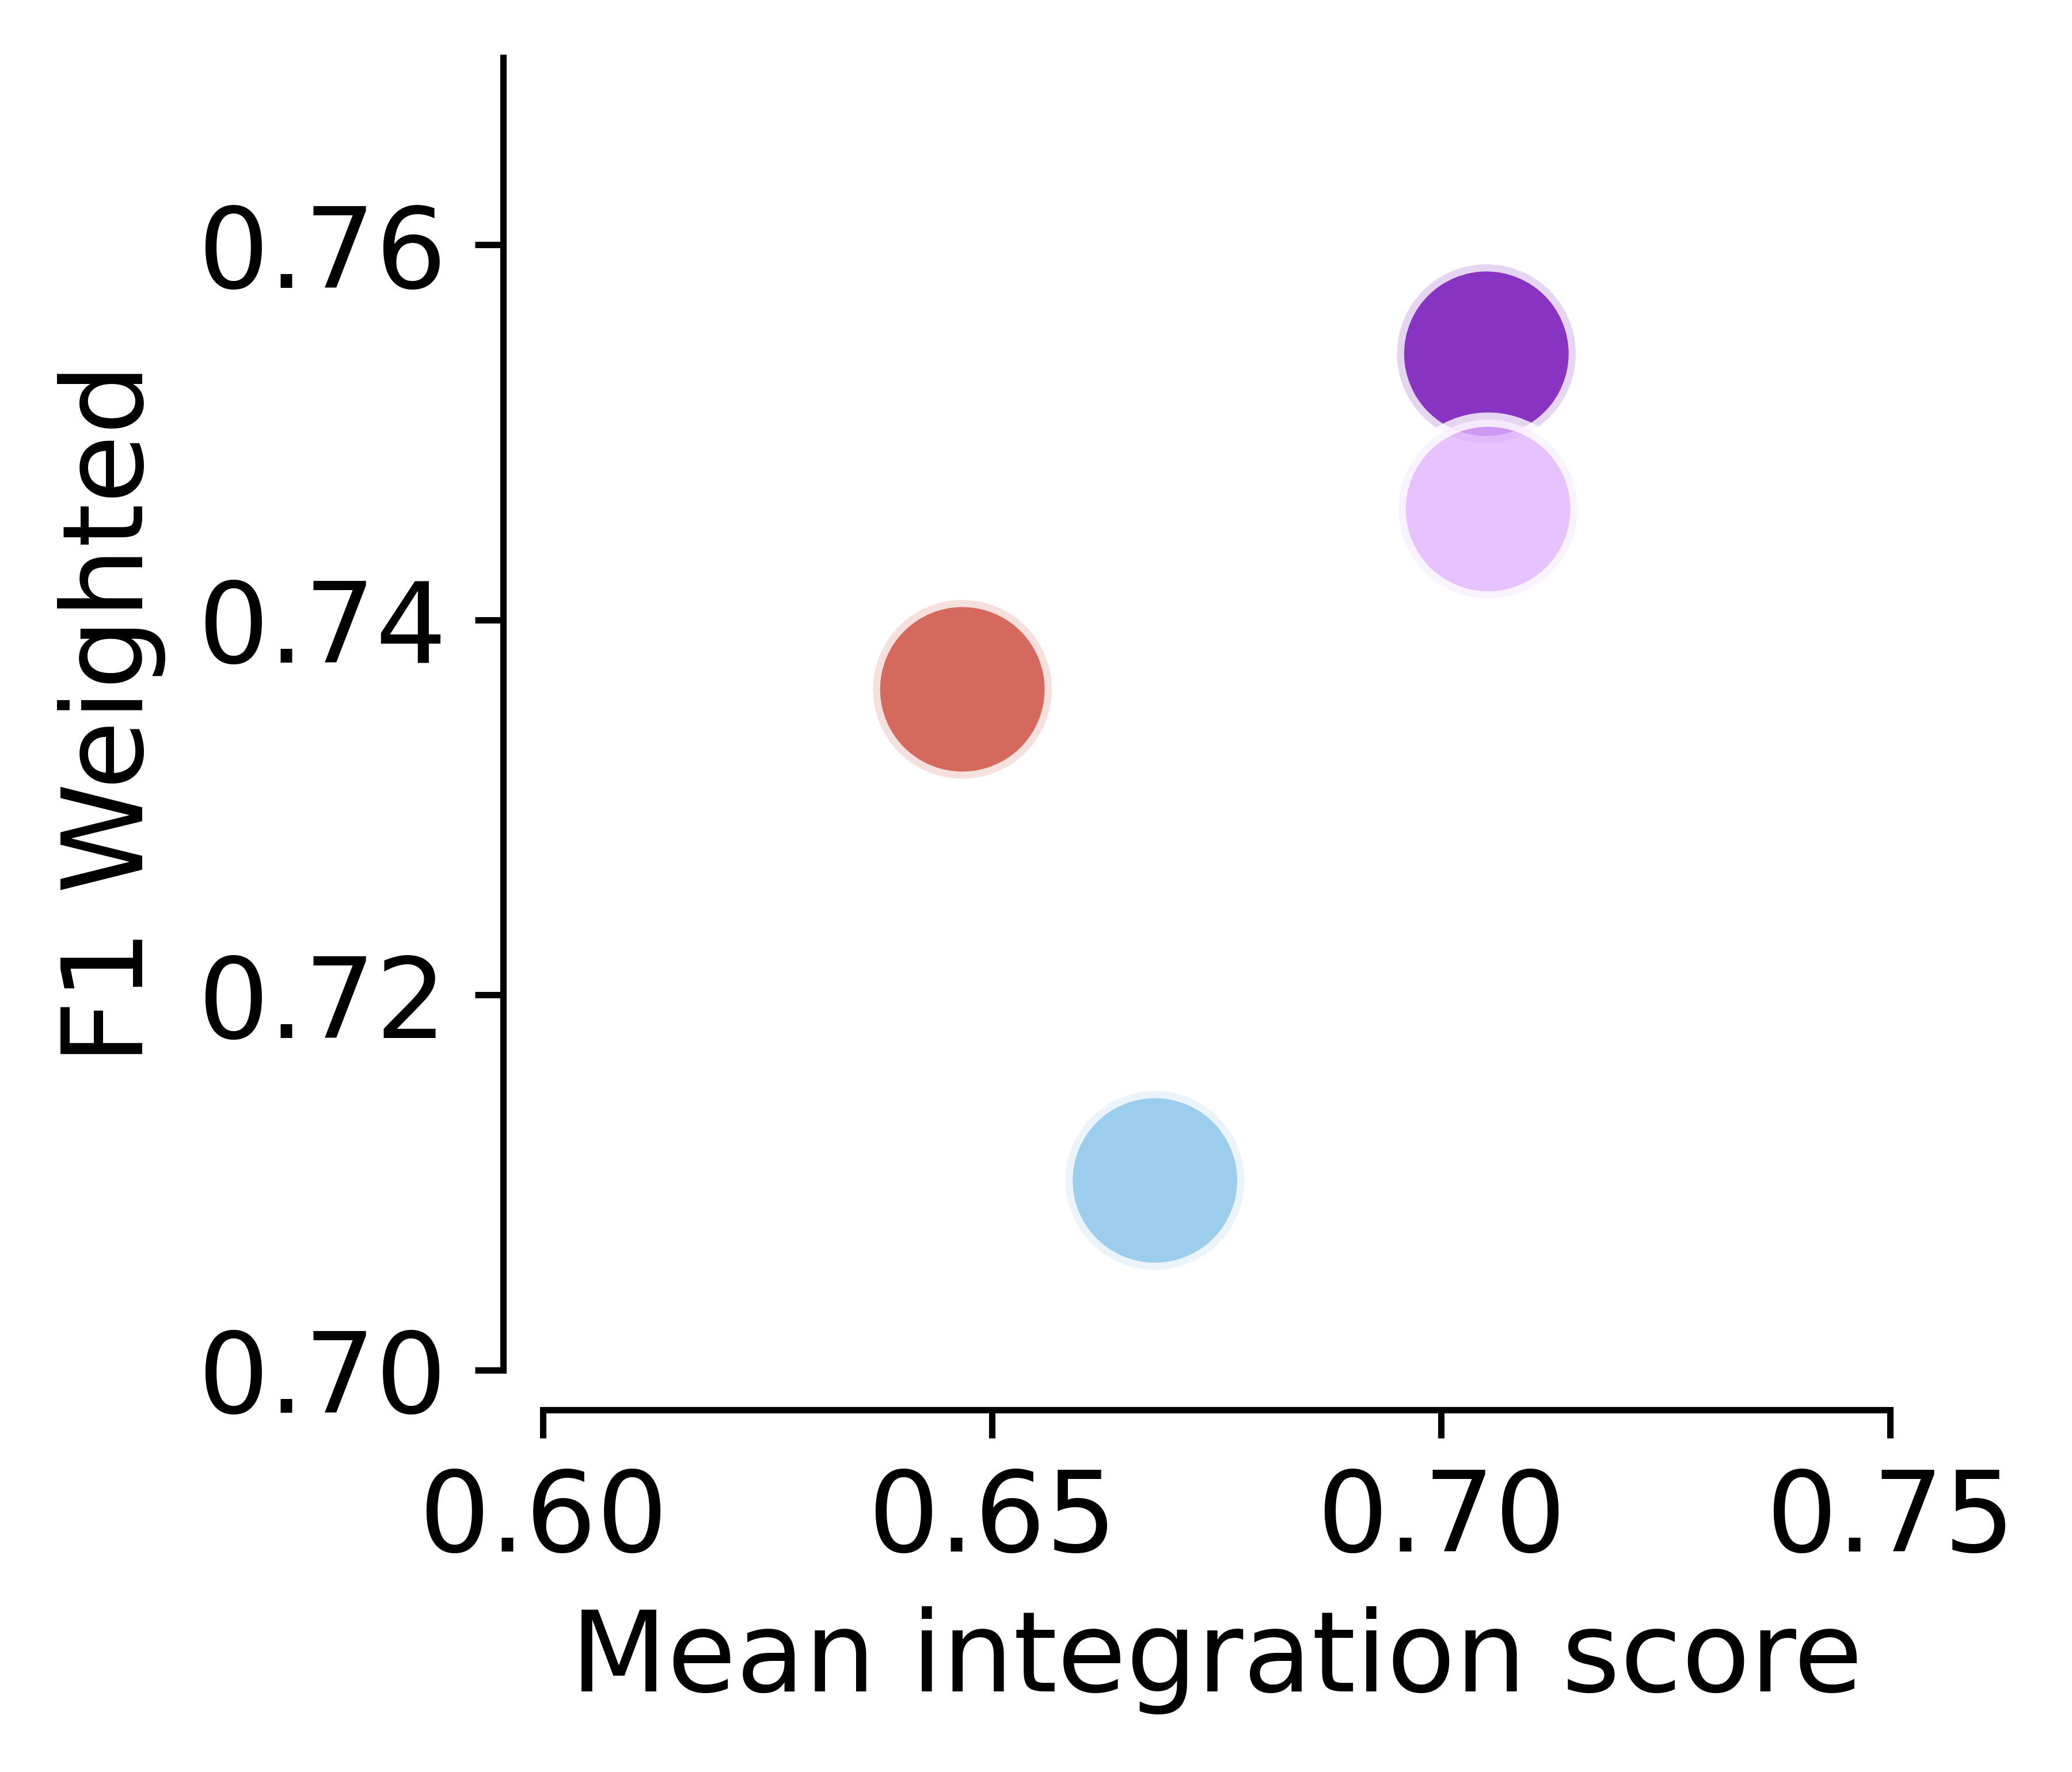

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-weighted'],
    hue=df_mean.index,
    #style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=500,
    alpha=0.8,
)
ax.set_ylabel('F1 Weighted')
ax.set_xlabel('Mean integration score')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.7, 0.77])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_comparison_f1weighted.png', dpi=600, bbox_inches='tight')

In [ ]:
results_melt['variable'].unique()

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
ax=ax.flatten()
for i, var in enumerate(results_melt['variable'].unique()[:10]):
    df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
        & (results_melt['variable'] == var)
    ]
    df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

    mean_df = df_plot.groupby('method').mean()
    mean_df = mean_df.reset_index()
    mean_df['index'] = 'avg'
    mean_df.columns = ['method', 'value', 'config.data']
    df_plot = df_plot.append(mean_df)

    #fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.barplot(
        x='config.data',
        y='value',
        hue='method',
        data=df_plot,
        palette=palette_dict,
        ax=ax[i]
    )
    ax[i].set_title(var.split('.')[-1])
    ax[i].set_ylabel('Score')
    ax[i].set_xlabel('Dataset')
    if i == 1:
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    else:
        ax[i].get_legend().remove()
    ax[i].set_ylim([0, 0.85])
    ax[i].grid('off')
    ax[i].grid(b=None)
    sns.despine(offset=5)
fig.tight_layout()
    #fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')